# Planteamiento de la solución

**Objetivo:** Predecir el riesgo de incumplimiento de nuevos clientes y asignar una tasa de interés de riesgo, minimizando el abandono del crédito y garantizando rentabilidad.

1) Exploración y limpieza de datos:

* Revisión de valores nulos, tipos de variables.

* Distribución de la variable NoPaidPercent, outliers y correlaciones.

2) Segmentación o modelamiento?:

* Opción A: Segmentar por perfil (ej: edad, nivel de ingresos, tipo de empleo).

* Opción B: Modelo predictivo individual (estimar el NoPaidPercent).

3) Modelos sugeridos:

* Regresión, Random Forest, XGBoost.

4) Conversión a interés:

* Opción 1: Tomar el NoPaidPercent esperado como porcentaje de pérdida y usarlo directo como el interés de riesgo.

* Opción2: Aplicar una fórmula como la siguiente
    * interés_riesgo = NPP_esperado * factor_de_seguridad (Donde factor_de_seguridad podría ser por ejemplo 0.5 – 1.5 para cubrir incertidumbre.)

# 1. Librerías y carga de datos

In [ ]:
#Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from xgboost import XGBRegressor

In [ ]:
# Cargar datasets directamente al colab antes de
historico = pd.read_csv("datos_historicos.csv")
nuevos = pd.read_csv("datos_nuevos_creditos.csv")

# 2. Exploración

## 2.1 Visualización de datos

In [ ]:
historico.head()

,ID,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,HomeOwnership,Education,MaritalStatus,YearsAtCurrentAddress,NoPaidPerc
0,1,384,0.016560,37950,20,0,2,17355,9,28,Mortgage,Bachelor,Divorced,18,0.196566
1,2,516,0.138825,22909,46,5,8,7175,13,0,Rent,Bachelor,Married,9,0.264438
2,3,638,0.391149,126521,80,5,7,1910,6,25,Rent,Bachelor,Single,9,0.287568
3,4,363,0.463521,39543,54,9,0,19339,5,22,Own,High School,Widowed,3,0.181348
4,5,804,0.504824,38522,72,1,10,7928,18,19,Own,PhD,Married,5,0.343376


In [ ]:
historico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               10000 non-null  int64  
 1   CreditScore                      10000 non-null  int64  
 2   DebtRatio                        10000 non-null  float64
 3   Assets                           10000 non-null  int64  
 4   Age                              10000 non-null  int64  
 5   NumberOfDependents               10000 non-null  int64  
 6   NumberOfOpenCreditLinesAndLoans  10000 non-null  int64  
 7   MonthlyIncome                    10000 non-null  int64  
 8   NumberOfTimesPastDue             10000 non-null  int64  
 9   EmploymentLength                 10000 non-null  int64  
 10  HomeOwnership                    10000 non-null  object 
 11  Education                        10000 non-null  object 
 12  MaritalStatus      

In [ ]:
nuevos.head()

,ID,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,HomeOwnership,Education,MaritalStatus,YearsAtCurrentAddress,NewLoanApplication
0,10001,737,0.479047,34979,63,6,12,2904,8,15,Mortgage,High School,Widowed,20,37752.0
1,10002,411,0.442930,56459,28,7,4,17639,11,4,Rent,High School,Widowed,21,52917.0
2,10003,732,0.532314,76570,26,5,8,17730,7,10,Rent,High School,Widowed,10,106380.0
3,10004,710,0.295541,86752,51,8,16,7166,16,18,Mortgage,Masters,Widowed,17,35830.0
4,10005,848,0.248378,102286,29,4,8,4688,16,1,Own,High School,Widowed,26,32816.0


In [ ]:
nuevos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               1058 non-null   int64  
 1   CreditScore                      1058 non-null   int64  
 2   DebtRatio                        1058 non-null   float64
 3   Assets                           1058 non-null   int64  
 4   Age                              1058 non-null   int64  
 5   NumberOfDependents               1058 non-null   int64  
 6   NumberOfOpenCreditLinesAndLoans  1058 non-null   int64  
 7   MonthlyIncome                    1058 non-null   int64  
 8   NumberOfTimesPastDue             1058 non-null   int64  
 9   EmploymentLength                 1058 non-null   int64  
 10  HomeOwnership                    1058 non-null   object 
 11  Education                        1058 non-null   object 
 12  MaritalStatus       

## 2.2 Datos duplicados o atípicos

In [ ]:
historico.isnull().sum()

,0
ID,0
CreditScore,0
DebtRatio,0
Assets,0
Age,0
NumberOfDependents,0
NumberOfOpenCreditLinesAndLoans,0
MonthlyIncome,0
NumberOfTimesPastDue,0
EmploymentLength,0


In [ ]:
nuevos.duplicated().sum()

np.int64(0)

In [ ]:
#Min y max de edad
historico['Age'].describe()

,Age
count,10000.00000
mean,53.21540
std,20.65087
min,18.00000
25%,35.75000
50%,53.00000
75%,71.00000
max,89.00000


In [ ]:
nuevos['Age'].describe()

,Age
count,1058.000000
mean,48.307183
std,20.253950
min,18.000000
25%,31.000000
50%,46.000000
75%,64.000000
max,89.000000


In [ ]:
historico['NoPaidPerc'].describe()

,NoPaidPerc
count,10000.000000
mean,0.226052
std,0.067179
min,0.000000
25%,0.198827
50%,0.233158
75%,0.267660
max,0.382792


## 2.3 Distribuciones

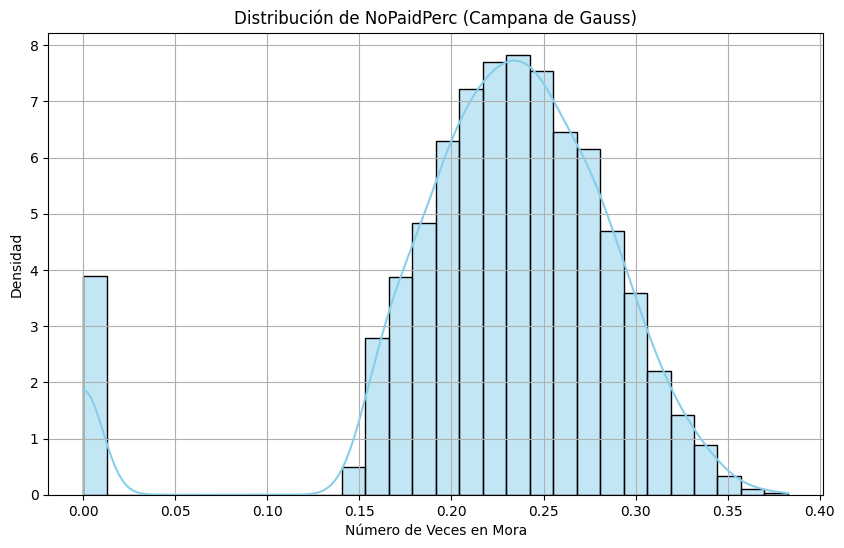

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(historico['NoPaidPerc'], kde=True, stat="density", bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de NoPaidPerc (Campana de Gauss)')
plt.xlabel('Número de Veces en Mora')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

## 2.4 Correlaciones

In [ ]:
# Copia del dataset histórico sin la columna 'ID'
df_corr = historico.drop(columns=['ID']).copy()

# One-hot encoding para convertir variables categóricas a numéricas
df_corr = pd.get_dummies(df_corr, drop_first=True)

# Calculamos la correlación de Pearson con respecto a NoPaidPerc
correlaciones = df_corr.corr()['NoPaidPerc'].sort_values(ascending=False)

# Mostramos todas las variables ordenadas por su correlación con NoPaidPerc
print("Correlaciones de todas las variables con 'NoPaidPerc':\n")
print(correlaciones)

Correlaciones de todas las variables con 'NoPaidPerc':

NoPaidPerc                         1.000000
MaritalStatus_Married              0.306737
DebtRatio                          0.302586
EmploymentLength                   0.213143
HomeOwnership_Own                  0.212328
Age                                0.183309
YearsAtCurrentAddress              0.154636
NumberOfOpenCreditLinesAndLoans    0.130869
MaritalStatus_Single               0.128015
Education_PhD                      0.120181
NumberOfTimesPastDue               0.093351
MonthlyIncome                     -0.044164
Assets                            -0.059429
CreditScore                       -0.069173
HomeOwnership_Rent                -0.144393
Education_High School             -0.145880
NumberOfDependents                -0.187542
Education_Masters                 -0.208506
MaritalStatus_Widowed             -0.502389
Name: NoPaidPerc, dtype: float64


## 2.5 Tratamientos

In [ ]:
# Listas de columnas para preprocesamiento
columnas_categoricas = ['HomeOwnership', 'Education', 'MaritalStatus']
columnas_excluir = columnas_categoricas + ['ID', 'NoPaidPerc']
columnas_numericas = [col for col in historico.columns if col not in columnas_excluir]

In [ ]:
# Procesador de las pipelines para encoding y normalización
preprocesador = ColumnTransformer(transformers=[
    ('num', StandardScaler(), columnas_numericas),
    ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
])

In [ ]:
# Separar variables
x1 = historico.drop(columns=['ID', 'NoPaidPerc'])
# ID Es solo un identificador único del cliente.
# NoPaidPerc es la variable objetivo que quieres predecir.
y1 = historico['NoPaidPerc']

In [ ]:
# Dividir los datos en 80% entrenamiento y 20% prueba
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

# 3. Modelado utilizando todas las variables

## 3.1 Ramdom Forest

In [ ]:
# Pipeline para RF
pipeline_rf = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('modelo', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [ ]:
# Entrenar el pipeline
pipeline_rf.fit(x_train, y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'DebtRatio',
                                                   'Assets', 'Age',
                                                   'NumberOfDependents',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'MonthlyIncome',
                                                   'NumberOfTimesPastDue',
                                                   'EmploymentLength',
                                                   'YearsAtCurrentAddress']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HomeOwnership', 'Education',
                                                   'MaritalStatus'])])),
                ('modelo', RandomForestRegressor(random_state=42))])

In [ ]:
# Predicción en entrenamiento
y_train_pred_rf = pipeline_rf.predict(x_train)

# Predecir sobre el test
y_test_pred_rf = pipeline_rf.predict(x_test)

In [ ]:
# Calcular métricas
resultados_rf = pd.DataFrame({
    "Conjunto": ["Entrenamiento", "Prueba"],
    "MAE": [
        mean_absolute_error(y_train, y_train_pred_rf),
        mean_absolute_error(y_test, y_test_pred_rf)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_train_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
    ],
    "R²": [
        r2_score(y_train, y_train_pred_rf),
        r2_score(y_test, y_test_pred_rf)
    ]
})

# Imprimir tabla
resultados_rf

,Conjunto,MAE,RMSE,R²
0,Entrenamiento,0.007829,0.011710,0.969609
1,Prueba,0.021858,0.033254,0.754598


## 3.2 Regresión Lineal

In [ ]:
pipeline_lr = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('modelo', LinearRegression())
])

In [ ]:
# Entrenar el pipeline
pipeline_lr.fit(x_train, y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'DebtRatio',
                                                   'Assets', 'Age',
                                                   'NumberOfDependents',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'MonthlyIncome',
                                                   'NumberOfTimesPastDue',
                                                   'EmploymentLength',
                                                   'YearsAtCurrentAddress']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HomeOwnership', 'Education',
                                                   'MaritalStatus'])])),
                ('modelo', LinearRegression())])

In [ ]:
# Predicción en entrenamiento
y_train_pred_rl = pipeline_lr.predict(x_train)

# Predecir sobre el test
y_test_pred_rl = pipeline_rf.predict(x_test)

In [ ]:
# Calcular métricas
resultados_rl = pd.DataFrame({
    "Conjunto": ["Entrenamiento", "Prueba"],
    "MAE": [
        mean_absolute_error(y_train, y_train_pred_rl),
        mean_absolute_error(y_test, y_test_pred_rl)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_train_pred_rl)),
        np.sqrt(mean_squared_error(y_test, y_test_pred_rl))
    ],
    "R²": [
        r2_score(y_train, y_train_pred_rl),
        r2_score(y_test, y_test_pred_rl)
    ]
})

# Imprimir tabla
resultados_rl

,Conjunto,MAE,RMSE,R²
0,Entrenamiento,0.026640,0.037668,0.685555
1,Prueba,0.021858,0.033254,0.754598


## 3.3 XGBoost

In [ ]:
# Pipeline con XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('modelo', XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42))
])

In [ ]:
# Entrenar el pipeline
pipeline_xgb.fit(x_train, y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'DebtRatio',
                                                   'Assets', 'Age',
                                                   'NumberOfDependents',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'MonthlyIncome',
                                                   'NumberOfTimesPastDue',
                                                   'EmploymentLength',
                                                   'YearsAtCurrentAddress']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HomeOwnership', 'Education',
                                                   'M...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Predicción en entrenamiento
y_train_pred_xgb = pipeline_xgb.predict(x_train)

# Predecir sobre el test
y_test_pred_xgb = pipeline_xgb.predict(x_test)

In [ ]:
# Calcular métricas
resultados_xgb = pd.DataFrame({
    "Conjunto": ["Entrenamiento", "Prueba"],
    "MAE": [
        mean_absolute_error(y_train, y_train_pred_xgb),
        mean_absolute_error(y_test, y_test_pred_xgb)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)),
        np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
    ],
    "R²": [
        r2_score(y_train, y_train_pred_xgb),
        r2_score(y_test, y_test_pred_xgb)
    ]
})

# Mostrar tabla
resultados_xgb

,Conjunto,MAE,RMSE,R²
0,Entrenamiento,0.019969,0.029505,0.807071
1,Prueba,0.022037,0.033534,0.750456


# 4. Modelo con leve selección de variables

In [ ]:
## Se deja a las variables con correlación almenos de 10%
variables_corr = correlaciones[correlaciones.abs() > 0.10].drop(columns=['ID', 'NoPaidPerc']).index.tolist()

## Definir x e y nuevamente
x2 = df_corr[variables_corr]
y2 = df_corr['NoPaidPerc']
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

In [ ]:
# def_corr ya tiene encoding, solo necesita normalizar
columnas_numericas2 = columnas_numericas2 = [col for col in x2_train.columns if col != 'NoPaidPerc']
preprocesador2 = ColumnTransformer([
    ('num', StandardScaler(), columnas_numericas2)
])

## 4.1 Ramdom Forest

In [ ]:
# Pipeline para RF
pipeline_rf2 = Pipeline(steps=[
    ('preprocesamiento', preprocesador2),
    ('modelo', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [ ]:
# Entrenar el pipeline
pipeline_rf2.fit(x2_train, y2_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['MaritalStatus_Married',
                                                   'DebtRatio',
                                                   'EmploymentLength',
                                                   'HomeOwnership_Own', 'Age',
                                                   'YearsAtCurrentAddress',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'MaritalStatus_Single',
                                                   'Education_PhD',
                                                   'HomeOwnership_Rent',
                                                   'Education_High School',
                                                   'NumberOfDependents',
                                                   'Education_Masters',
                                                   'MaritalStatus_Widowed'])])),
                ('modelo', RandomForestRegressor(random_state=42))])

In [ ]:
# Predicción en entrenamiento
y2_train_pred_rf = pipeline_rf2.predict(x2_train)

# Predecir sobre el test
y2_test_pred_rf = pipeline_rf2.predict(x2_test)

In [ ]:
# Calcular métricas
resultados_rf2 = pd.DataFrame({
    "Conjunto": ["Entrenamiento", "Prueba"],
    "MAE": [
        mean_absolute_error(y2_train, y2_train_pred_rf),
        mean_absolute_error(y2_test, y2_test_pred_rf)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y2_train, y2_train_pred_rf)),
        np.sqrt(mean_squared_error(y2_test, y2_test_pred_rf))
    ],
    "R²": [
        r2_score(y2_train, y2_train_pred_rf),
        r2_score(y2_test, y2_test_pred_rf)
    ]
})

# Imprimir tabla
resultados_rf2

,Conjunto,MAE,RMSE,R²
0,Entrenamiento,0.008537,0.012762,0.963906
1,Prueba,0.024627,0.037646,0.685509


## 4.2 Regresión Lineal

In [ ]:
pipeline_lr2 = Pipeline(steps=[
    ('preprocesamiento', preprocesador2),
    ('modelo', LinearRegression())
])

In [ ]:
# Entrenar el pipeline
pipeline_lr2.fit(x2_train, y2_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['MaritalStatus_Married',
                                                   'DebtRatio',
                                                   'EmploymentLength',
                                                   'HomeOwnership_Own', 'Age',
                                                   'YearsAtCurrentAddress',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'MaritalStatus_Single',
                                                   'Education_PhD',
                                                   'HomeOwnership_Rent',
                                                   'Education_High School',
                                                   'NumberOfDependents',
                                                   'Education_Masters',
                                                   'MaritalStatus_Widowed'])])),
                ('modelo', LinearRegression())])

In [ ]:
# Predicción en entrenamiento
y2_train_pred_rl = pipeline_lr2.predict(x2_train)

# Predecir sobre el test
y2_test_pred_rl = pipeline_rf2.predict(x2_test)

In [ ]:
# Calcular métricas
resultados_rl2 = pd.DataFrame({
    "Conjunto": ["Entrenamiento", "Prueba"],
    "MAE": [
        mean_absolute_error(y2_train, y2_train_pred_rl),
        mean_absolute_error(y2_test, y2_test_pred_rl)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y2_train, y2_train_pred_rl)),
        np.sqrt(mean_squared_error(y2_test, y2_test_pred_rl))
    ],
    "R²": [
        r2_score(y2_train, y2_train_pred_rl),
        r2_score(y2_test, y2_test_pred_rl)
    ]
})

# Imprimir tabla
resultados_rl2

,Conjunto,MAE,RMSE,R²
0,Entrenamiento,0.027420,0.038921,0.664289
1,Prueba,0.024627,0.037646,0.685509


## 4.3 XGBoost

In [ ]:
# Pipeline con XGBoost
pipeline_xgb2 = Pipeline(steps=[
    ('preprocesamiento', preprocesador2),
    ('modelo', XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42))
])

In [ ]:
# Entrenar el pipeline
pipeline_xgb2.fit(x2_train, y2_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['MaritalStatus_Married',
                                                   'DebtRatio',
                                                   'EmploymentLength',
                                                   'HomeOwnership_Own', 'Age',
                                                   'YearsAtCurrentAddress',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'MaritalStatus_Single',
                                                   'Education_PhD',
                                                   'HomeOwnership_Rent',
                                                   'Education_High School',
                                                   'NumberOfDependents',
                                                   'Education_Mas...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Predicción en entrenamiento
y2_train_pred_xgb = pipeline_xgb2.predict(x2_train)

# Predecir sobre el test
y2_test_pred_xgb = pipeline_xgb2.predict(x2_test)

In [ ]:
# Calcular métricas
resultados_xgb2 = pd.DataFrame({
    "Conjunto": ["Entrenamiento", "Prueba"],
    "MAE": [
        mean_absolute_error(y2_train, y2_train_pred_xgb),
        mean_absolute_error(y2_test, y2_test_pred_xgb)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y2_train, y2_train_pred_xgb)),
        np.sqrt(mean_squared_error(y2_test, y2_test_pred_xgb))
    ],
    "R²": [
        r2_score(y2_train, y2_train_pred_xgb),
        r2_score(y2_test, y2_test_pred_xgb)
    ]
})

# Mostrar tabla
resultados_xgb2

,Conjunto,MAE,RMSE,R²
0,Entrenamiento,0.022199,0.032376,0.767700
1,Prueba,0.024116,0.036470,0.704849


# 5. Selección de modelo y predicción sobre clientes nuevos

Se optó por el modelo XGBoost con todas las variables

## 5.1 Búsquedad de hiperparámetros

In [ ]:
param_grid = {
    'modelo__n_estimators': [100, 200, 300],
    'modelo__max_depth': [3, 5, 7],
    'modelo__learning_rate': [0.01, 0.05, 0.1],
    'modelo__subsample': [0.8, 1],
    'modelo__colsample_bytree': [0.8, 1]
}

grid = GridSearchCV(pipeline_xgb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid.fit(x_train, y_train)

# Mejor modelo
best_model = grid.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
# Predicciones con el mejor modelo
y3_train_pred_xgb = best_model.predict(x_train)
y3_test_pred_xgb = best_model.predict(x_test)

In [ ]:
# Calcular métricas
resultados_xgb3 = pd.DataFrame({
    "Conjunto": ["Entrenamiento", "Prueba"],
    "MAE": [
        mean_absolute_error(y_train, y3_train_pred_xgb),
        mean_absolute_error(y_test, y3_test_pred_xgb)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y3_train_pred_xgb)),
        np.sqrt(mean_squared_error(y_test, y3_test_pred_xgb))
    ],
    "R²": [
        r2_score(y_train, y3_train_pred_xgb),
        r2_score(y_test, y3_test_pred_xgb)
    ]
})

# Mostrar tabla
resultados_xgb3

,Conjunto,MAE,RMSE,R²
0,Entrenamiento,0.010127,0.014400,0.954046
1,Prueba,0.017924,0.027734,0.829313


Aunque la diferencia de R² es de 0.12, el valor en prueba sigue siendo alto y además, los valores de MAE y RMSE no se disparan, son bajos en ambos conjuntos. Podría considerarse levemente sobreentrenado, pero aún útil y confiable.

## 5.3 Predicciones clientes nuevos

In [ ]:
# Se escogió XGBoost con todas las variables y búsquedad de hiperparámetros
predicciones_NoPaidPercen = best_model.predict(nuevos)
df_predicciones = pd.DataFrame({
    'ID': nuevos['ID'].values,
    'int_rc': predicciones_NoPaidPercen
})
df_predicciones.head(10)

,ID,int_rc
0,10001,0.144324
1,10002,0.095322
2,10003,0.093006
3,10004,0.107538
4,10005,0.017323
5,10006,0.154819
6,10007,0.150690
7,10008,-0.026101
8,10009,0.152633
9,10010,0.176109


In [ ]:
df_predicciones['int_rc'].describe()

,int_rc
count,1058.000000
mean,0.096666
std,0.061929
min,-0.062424
25%,0.038477
50%,0.120340
75%,0.151559
max,0.213815


In [ ]:
print(df_predicciones[df_predicciones['int_rc'] < 0])

         ID    int_rc
7     10008 -0.026101
39    10040 -0.006614
45    10046 -0.011155
96    10097 -0.022602
105   10106 -0.015961
123   10124 -0.001193
126   10127 -0.012780
169   10170 -0.004154
178   10179 -0.003050
187   10188 -0.033156
206   10207 -0.018924
213   10214 -0.014819
244   10245 -0.014103
251   10252 -0.049005
287   10288 -0.016544
300   10301 -0.003537
315   10316 -0.039232
316   10317 -0.041213
339   10340 -0.007525
349   10350 -0.011679
355   10356 -0.001849
390   10391 -0.009203
416   10417 -0.001958
434   10435 -0.041048
443   10444 -0.000148
460   10461 -0.036880
465   10466 -0.011213
470   10471 -0.017491
500   10501 -0.000360
526   10527 -0.053119
534   10535 -0.028441
548   10549 -0.054903
555   10556 -0.005485
574   10575 -0.010929
575   10576 -0.028519
616   10617 -0.002761
626   10627 -0.014979
630   10631 -0.010458
638   10639 -0.006698
664   10665 -0.021408
681   10682 -0.028822
744   10745 -0.007589
758   10759 -0.004899
768   10769 -0.018471
770   1077

In [ ]:
# En la práctica, un interés de riesgo negativo se puede interpretar como cero, ya que representa que el cliente no tiene prácticamente riesgo
df_predicciones['int_rc'] = df_predicciones['int_rc'].clip(lower=0)

## 5.4 Validaciones para segmentación

Se optó por una estimación individual del riesgo, aprovechando la precisión del modelo, lo cual permite una personalización justa y competitiva en la tasa de interés.

In [ ]:
df_validacion = nuevos.copy()
df_validacion = df_validacion.merge(df_predicciones[['ID', 'int_rc']], on='ID')

In [ ]:
df_validacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               1058 non-null   int64  
 1   CreditScore                      1058 non-null   int64  
 2   DebtRatio                        1058 non-null   float64
 3   Assets                           1058 non-null   int64  
 4   Age                              1058 non-null   int64  
 5   NumberOfDependents               1058 non-null   int64  
 6   NumberOfOpenCreditLinesAndLoans  1058 non-null   int64  
 7   MonthlyIncome                    1058 non-null   int64  
 8   NumberOfTimesPastDue             1058 non-null   int64  
 9   EmploymentLength                 1058 non-null   int64  
 10  HomeOwnership                    1058 non-null   object 
 11  Education                        1058 non-null   object 
 12  MaritalStatus       

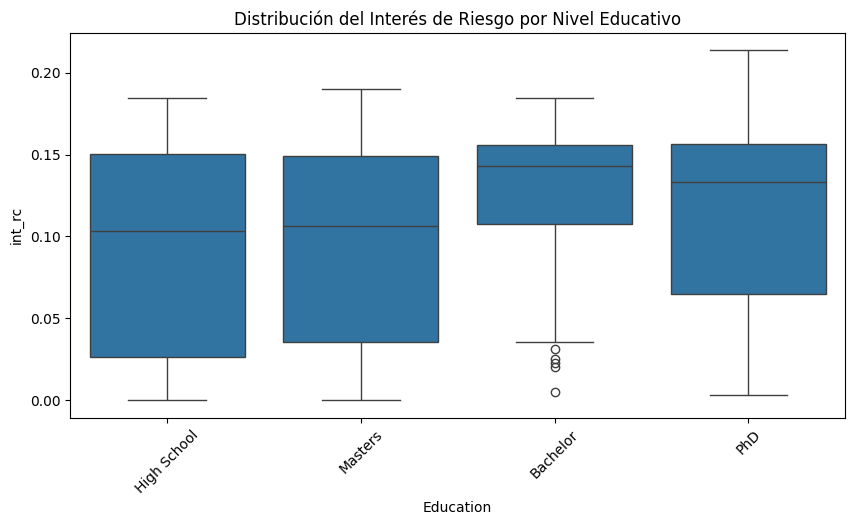

In [ ]:
# Educación vs Interés de riesgo
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_validacion, x='Education', y='int_rc')
plt.title("Distribución del Interés de Riesgo por Nivel Educativo")
plt.xticks(rotation=45)
plt.show()

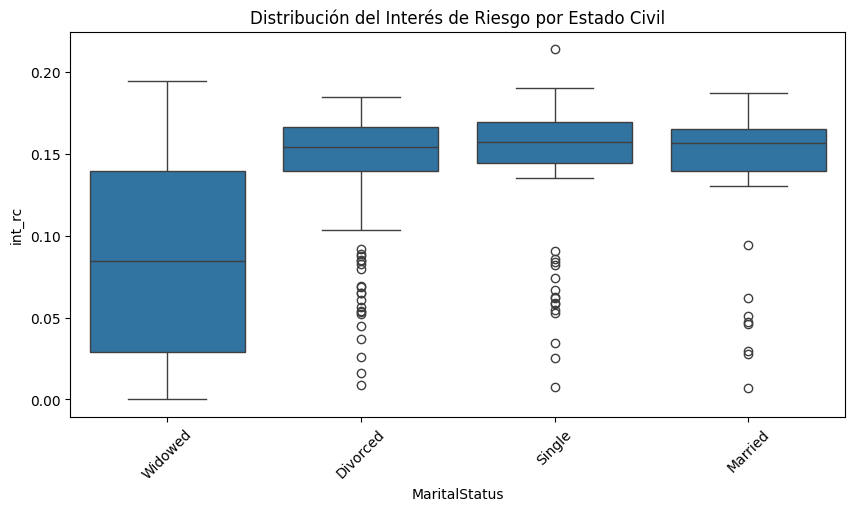

In [ ]:
# Estado civil vs Interés de riesgo
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_validacion, x='MaritalStatus', y='int_rc')
plt.title("Distribución del Interés de Riesgo por Estado Civil")
plt.xticks(rotation=45)
plt.show()

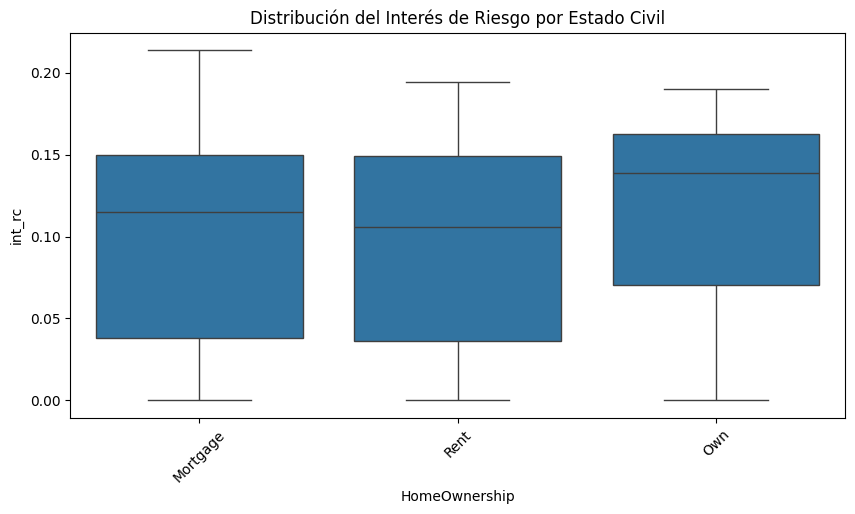

In [ ]:
# Estado civil vs Interés de riesgo
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_validacion, x='HomeOwnership', y='int_rc')
plt.title("Distribución del Interés de Riesgo por Estado Civil")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Correlaciones
correlaciones_validacion = df_validacion.select_dtypes(include='number').corr()['int_rc'].sort_values(ascending=False)

# Mostrar top 10
correlaciones_validacion

,int_rc
int_rc,1.000000
DebtRatio,0.197331
EmploymentLength,0.080369
ID,0.049676
YearsAtCurrentAddress,0.034917
NumberOfTimesPastDue,0.031697
NewLoanApplication,0.031373
NumberOfOpenCreditLinesAndLoans,0.017415
MonthlyIncome,0.009511
Assets,-0.011810


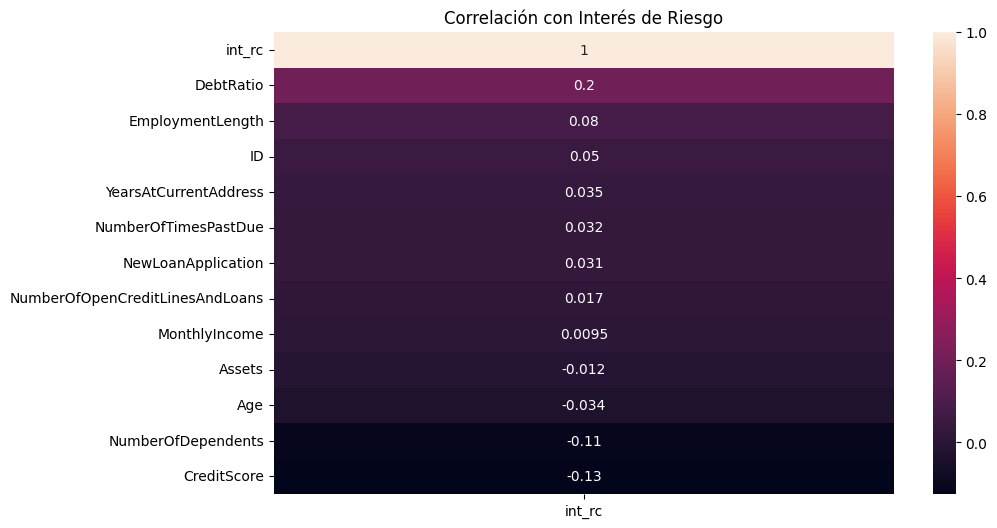

In [ ]:
# Visual
plt.figure(figsize=(10,6))
sns.heatmap(df_validacion.select_dtypes(include='number').corr()[['int_rc']].sort_values(by='int_rc', ascending=False), annot=True)
plt.title('Correlación con Interés de Riesgo')
plt.show()

En las categóricas, mediante diagramas de caja no se observaron patrones claramente diferenciadores en la distribución del interés de riesgo. En las numéricas, ninguna variable presentó una correlación suficientemente fuerte con el interés de riesgo. Por lo tanto, no se evidencia una estructura de agrupación o segmentación que justifique políticas diferenciadas.

## 5.5 Definición de tasa de riesgo

Se decide multiplicar el NoPaidPercen esperado por un factor de seguridad. Esto cubre la incertidumbre del modelo para que encaso de desviaciones o eventos extremos, el banco no perda dinero. Además, es más conservador y prudente financieramente.

Este factor lo podemos definir basandonos en el error del modeo. El MAE de prueba (0.018) significa que en promedio el modelo se equivoca en un 1.8 puntos porcentuales. Adicional, RMSE (≈ 2.7%) indica que algunos errores son un poco mayores, pero sin ser descontrolados.

Pudiendo entonces definir la tasa de riesgo como:
* interes_riesgo = NoPaidPerc_predicho + MAE

Ejemplo:
Si el modelo predice 12% entonces el interes de riego es interes_riesgo = 0.12 + 0.018 = 13.8%

In [ ]:
# MAE del modelo en el conjunto de prueba
mae_prueba = 0.017924  # 1.79% en puntos decimales

# Crear el DataFrame final con la tasa de interés de riesgo ajustada
df_resultados = df_predicciones.copy()
df_resultados['int_rc'] = df_resultados['int_rc'] + mae_prueba

In [ ]:
df_resultados

,ID,int_rc
0,10001,0.162248
1,10002,0.113246
2,10003,0.110930
3,10004,0.125462
4,10005,0.035247
...,...,...
1053,11054,0.174187
1054,11055,0.176083
1055,11056,0.186423
1056,11057,0.077531


In [ ]:
df_resultados['int_rc'].describe()

,int_rc
count,1058.000000
mean,0.115444
std,0.060348
min,0.017924
25%,0.056401
50%,0.138264
75%,0.169483
max,0.231739


In [ ]:
print(df_resultados[df_resultados['int_rc'] < 0])

Empty DataFrame
Columns: [ID, int_rc]
Index: []


In [ ]:
# En la práctica, un interés de riesgo negativo se puede interpretar como cero, ya que representa que el cliente no tiene prácticamente riesgo
df_resultados['int_rc'] = df_resultados['int_rc'].clip(lower=0)

## 5.6 Exportar archivo csv

In [ ]:
df_resultados.to_csv('grupo4.csv', index=False)